In [8]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import geopandas as gpd
import pickle

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [20,16]

data_location = "/project/rcc/deep_learning_hack/dc-taxi/DCTaxiCab/data/intermediate/"
plot_location = data_location + "plot/"
data_file = "taxi_2017_02.csv"

In [2]:
sample_DF = pd.read_csv(data_location + data_file)

/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sample_DF.shape

(949578, 28)

In [4]:
sample_DF.columns = [x.upper() for x in sample_DF.columns.tolist()]

list(sample_DF)

sample_DF = sample_DF[~sample_DF.isnull().any(axis=1)]

sample_DF.dtypes

sample_DF['DROPOFF_BLOCK_LONGITUDE'] = sample_DF['DROPOFF_BLOCK_LONGITUDE'].apply(lambda x: ''.join(x.split()), 1).astype('double')
sample_DF['DROPOFF_BLOCK_LATITUDE'] = sample_DF['DROPOFF_BLOCK_LATITUDE'].apply(lambda x: ''.join(x.split()), 1).astype('double')
sample_DF['PICKUP_BLOCK_LONGITUDE'] = sample_DF['PICKUP_BLOCK_LONGITUDE'].apply(lambda x: ''.join(x.split()), 1).astype('double')
sample_DF['PICKUP_BLOCK_LATITUDE'] = sample_DF['PICKUP_BLOCK_LATITUDE'].apply(lambda x: ''.join(x.split()), 1).astype('double')
sample_DF['DROPOFFDATETIME_TR'] = sample_DF['DROPOFFDATETIME_TR'].astype('datetime64[ns]')

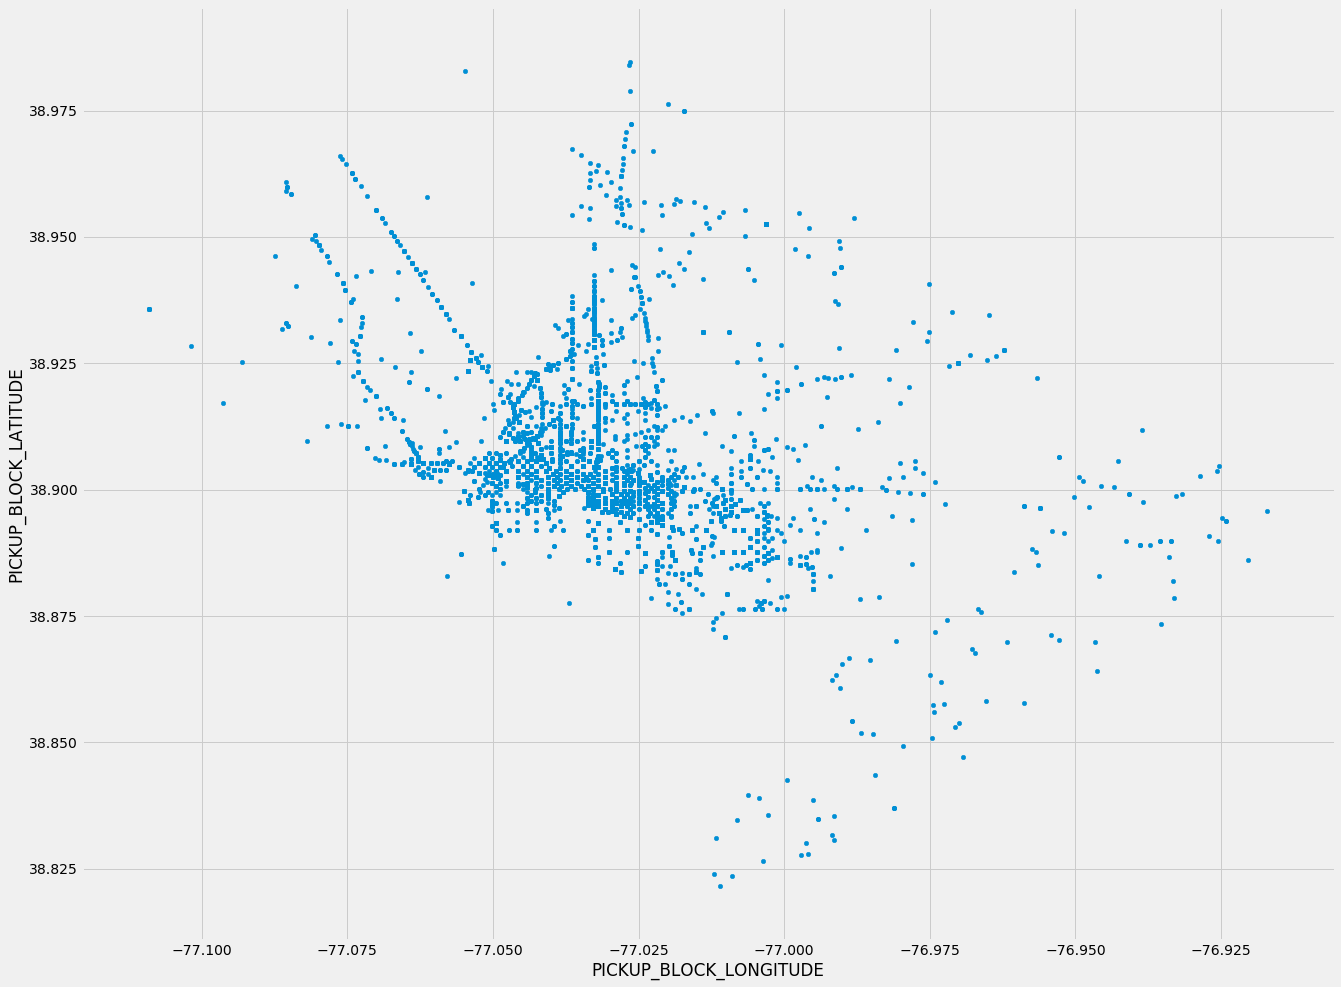

In [9]:
sample_DF.plot.scatter('PICKUP_BLOCK_LONGITUDE', 'PICKUP_BLOCK_LATITUDE')

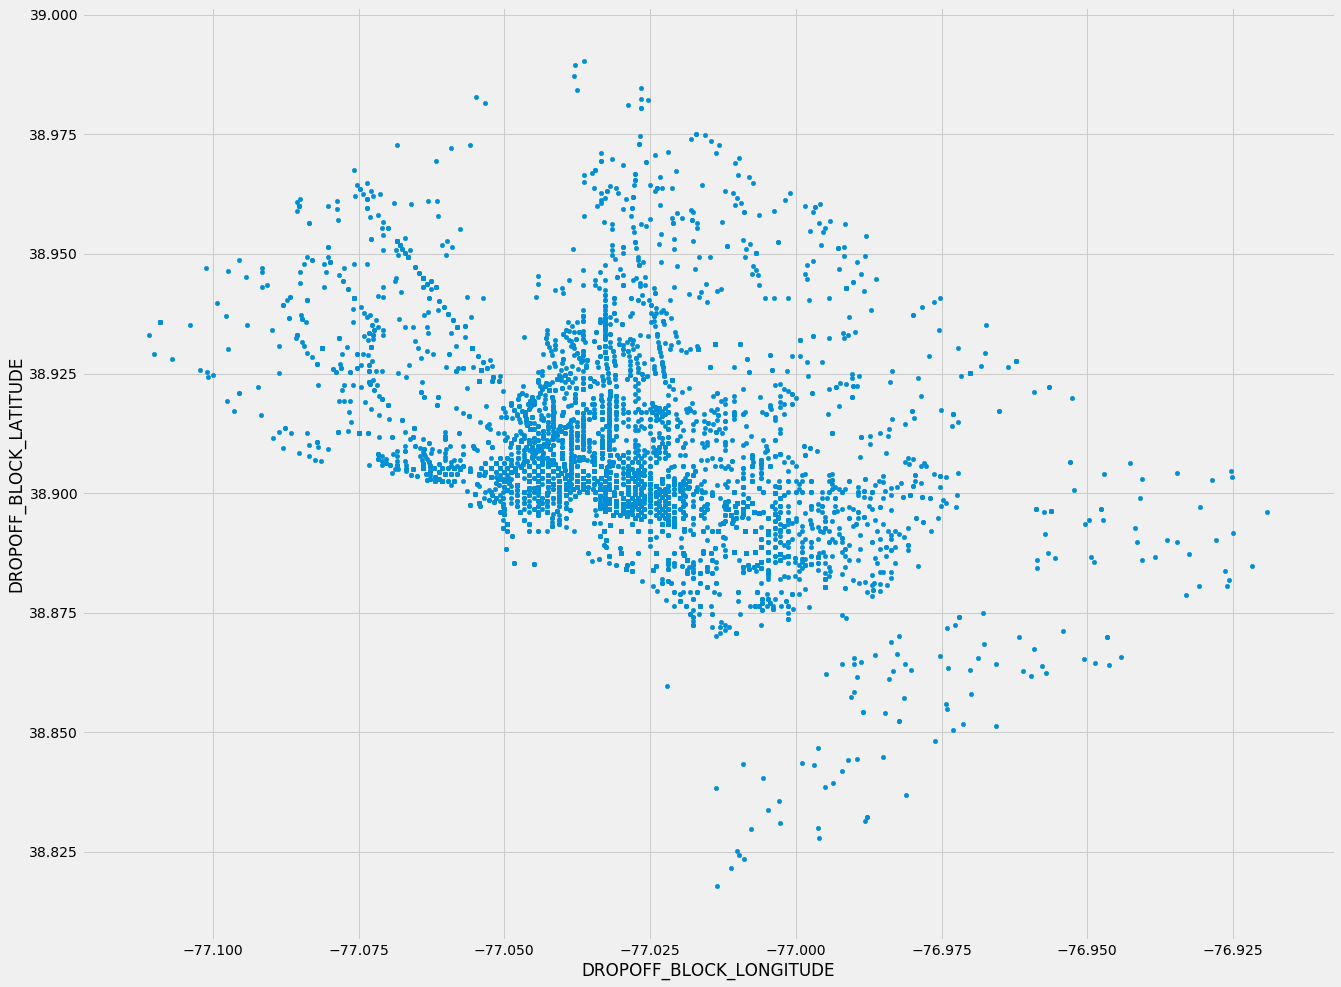

In [10]:
sample_DF.plot.scatter('DROPOFF_BLOCK_LONGITUDE', 'DROPOFF_BLOCK_LATITUDE')

In [7]:
# ax = plt.axes()
# ax.set_xlim(-77.2, -76.8)
# ax.set_ylim(38.800, 39.000)

# for i in range(0,sample_DF.shape[0]):
#     ax.arrow(sample_DF.PICKUP_BLOCK_LONGITUDE[i],
#              sample_DF.PICKUP_BLOCK_LATITUDE[i],
#              sample_DF.DROPOFF_BLOCK_LONGITUDE[i],
#              sample_DF.DROPOFF_BLOCK_LATITUDE[i],
#              head_width=0.05, 
#              head_length=0.1, fc='k', ec='k')
# plt.show()

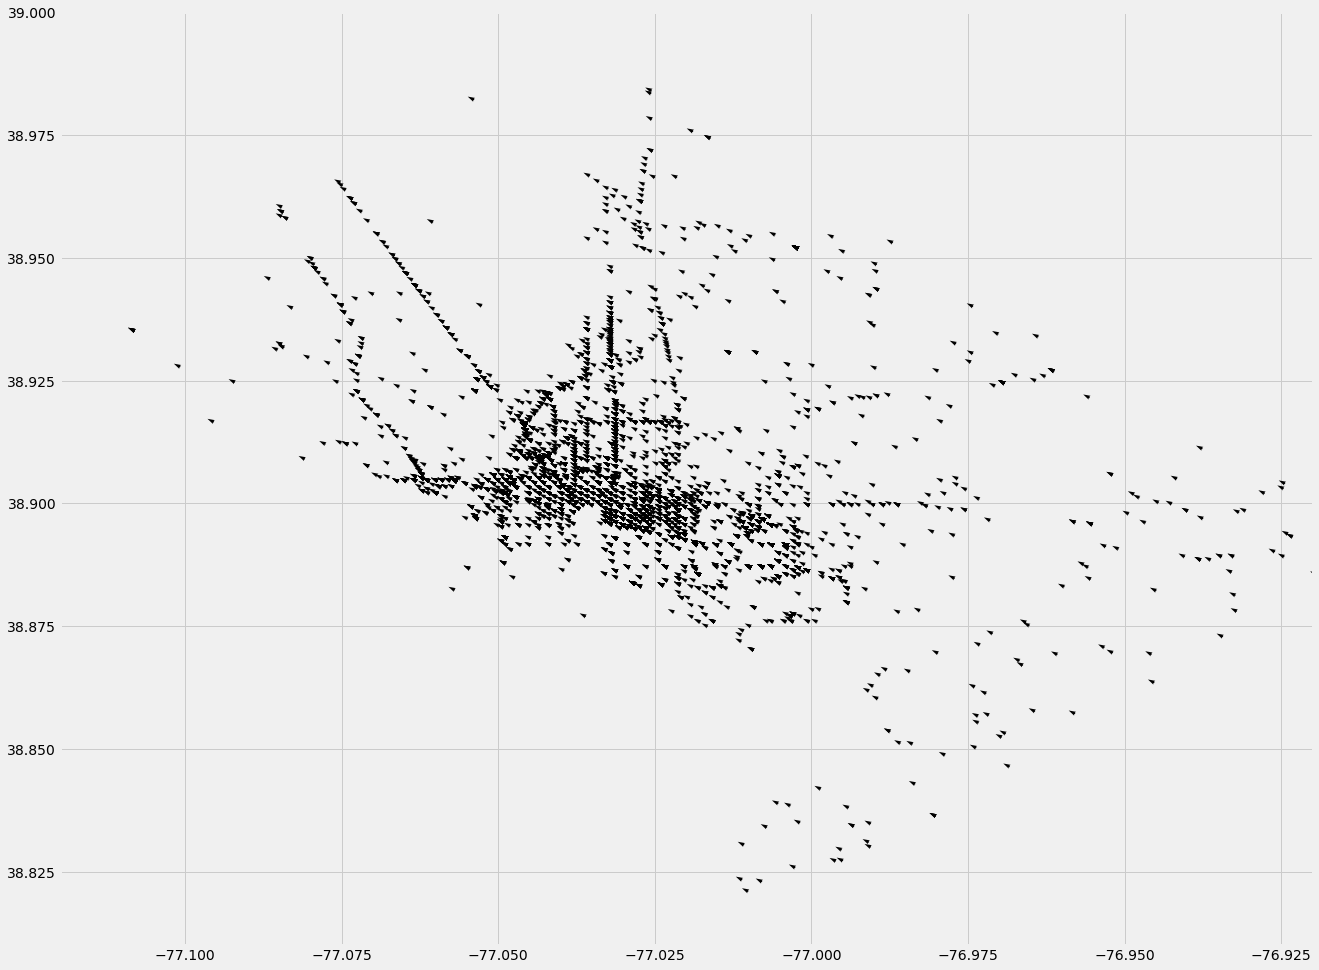

In [11]:
# Quiver Plot
plt.figure()
plt.xlim(-77.12, -76.92)
plt.ylim(38.810, 39.000)

plt.quiver(sample_DF.PICKUP_BLOCK_LONGITUDE,
             sample_DF.PICKUP_BLOCK_LATITUDE,
             sample_DF.DROPOFF_BLOCK_LONGITUDE,
             sample_DF.DROPOFF_BLOCK_LATITUDE,
           units = "x", pivot='tip')
plt.show()

# Coincidence Analysis

In [12]:
# Squares of Interest
# Top Left then bottom right
# [Latitude, Longtitude]
WH_square = [[38.901187, -77.041623],[38.895062, -77.031594]] 
CP_square = [[38.896103, -77.012120], [38.884442, -77.003512]]
FBI_square = [[38.896405, -77.026258], [38.893540, -77.023260]]
WP_square = [[38.903954, -77.032217], [38.902334, -77.029411]]

In [13]:
'''
in_square
Returns a boolean of True/False if the coordinate 
is in the square or not.

Sample Usage: in_square(WH_square[0][0], WH_square[0][1], WH_square)
'''
def in_square(coordinate_lat, coordinate_lon, square_coordinates):
    if square_coordinates[1][0] <= coordinate_lat <= square_coordinates[0][0]:
        if square_coordinates[0][1] <= coordinate_lon <= square_coordinates[1][1]:
            return True
    return False

In [14]:
in_square(WH_square[0][0], WH_square[0][1], WH_square)

True

In [15]:
DF = sample_DF
square_1 = WH_square
square_2 = WP_square
time_range =  pd.Timedelta('1 hour')

In [16]:
# Reduce DF to only rides originating out of the white house
in_square_1 = DF[['PICKUP_BLOCK_LATITUDE','PICKUP_BLOCK_LONGITUDE']].apply(lambda row: in_square(row[0], row[1], square_1), 1)
in_square_2 = DF[['PICKUP_BLOCK_LATITUDE','PICKUP_BLOCK_LONGITUDE']].apply(lambda row: in_square(row[0], row[1], square_2), 1)

In [17]:
np.count_nonzero(in_square_1)/len(in_square_1)

0.06568963725184493

In [18]:
np.count_nonzero(in_square_2)/len(in_square_2)

0.005093025673006964

In [19]:
DF = DF[in_square_1 | in_square_2]

In [20]:
dropoff_DF = DF[['DROPOFF_BLOCK_LATITUDE','DROPOFF_BLOCK_LONGITUDE']].drop_duplicates()
subset_DF = DF[['DROPOFF_BLOCK_LATITUDE','DROPOFF_BLOCK_LONGITUDE', 'PICKUP_BLOCK_LATITUDE','PICKUP_BLOCK_LONGITUDE',"DROPOFFDATETIME_TR"]]
subset_DF['DROPOFFDATETIME_TR'] = subset_DF['DROPOFFDATETIME_TR'].astype('datetime64[ns]')

/software/Anaconda3-5.0.1-el7-x86_64/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [21]:
print(dropoff_DF.shape)
print(subset_DF.shape)

(410, 2)
(681, 5)


In [22]:
result_list = []

for dropoff_index, dropoff_row in dropoff_DF.iterrows():
    dropoff_lat = dropoff_row[0]
    dropoff_lon = dropoff_row[1]
    # Check if pickups are an hour apart
    pickup_DF = subset_DF.loc[(subset_DF['DROPOFF_BLOCK_LATITUDE'] == dropoff_lat) & (subset_DF['DROPOFF_BLOCK_LONGITUDE'] == dropoff_lon)]
    if pickup_DF.shape[0] == 1:
        continue
    for pickup_index_1 in range(pickup_DF.shape[0] - 1):
        for pickup_index_2 in range(pickup_index_1 + 1, pickup_DF.shape[0]):
            # Check if they are within an hour of each other
            date_1 = pickup_DF.iloc[pickup_index_1]['DROPOFFDATETIME_TR']
            date_2 = pickup_DF.iloc[pickup_index_2]['DROPOFFDATETIME_TR']
            if abs(date_2 - date_1) <= time_range:
                result_list.append([pickup_DF.index[pickup_index_1], pickup_DF.index[pickup_index_2]])
        
        
## Check if their pickup areas are in the locational squares of interest
#                pickup_list_1 = [pickup_DF.iloc[pickup_index_1]['PICKUP_BLOCK_LATITUDE'], 
#                                 pickup_DF.iloc[pickup_index_1]['PICKUP_BLOCK_LONGITUDE']]
#                pickup_list_2 = [pickup_DF.iloc[pickup_index_2]['PICKUP_BLOCK_LATITUDE'], 
#                                 pickup_DF.iloc[pickup_index_2]['PICKUP_BLOCK_LONGITUDE']]
#                if in_square(pickup_list_1, square_1) and in_square(pickup_list_2, square_2):
#                    # Add results to list    

In [23]:
len(result_list)

133

In [24]:
# Save results list
pickle.dump(result_list, open(data_location + "result_list.p", "wb"))
# result_list = pickle.load( open( "result_list.p", "rb" ) )

## Plot the Coincidence by Day

In [25]:
plot_DF = sample_DF
plot_DF['DROPOFFDATETIME_TR'] = plot_DF['DROPOFFDATETIME_TR'].astype('datetime64[ns]')

In [27]:
date_list = []

for results_pair in result_list:
    first_index = results_pair[0]
    date_list.append(plot_DF.loc[first_index]['DROPOFFDATETIME_TR']) # iloc
        

In [28]:
date_DF = pd.DataFrame({"date": date_list})
#date_DF
graph_count_DF = date_DF.groupby(["date"]).size()

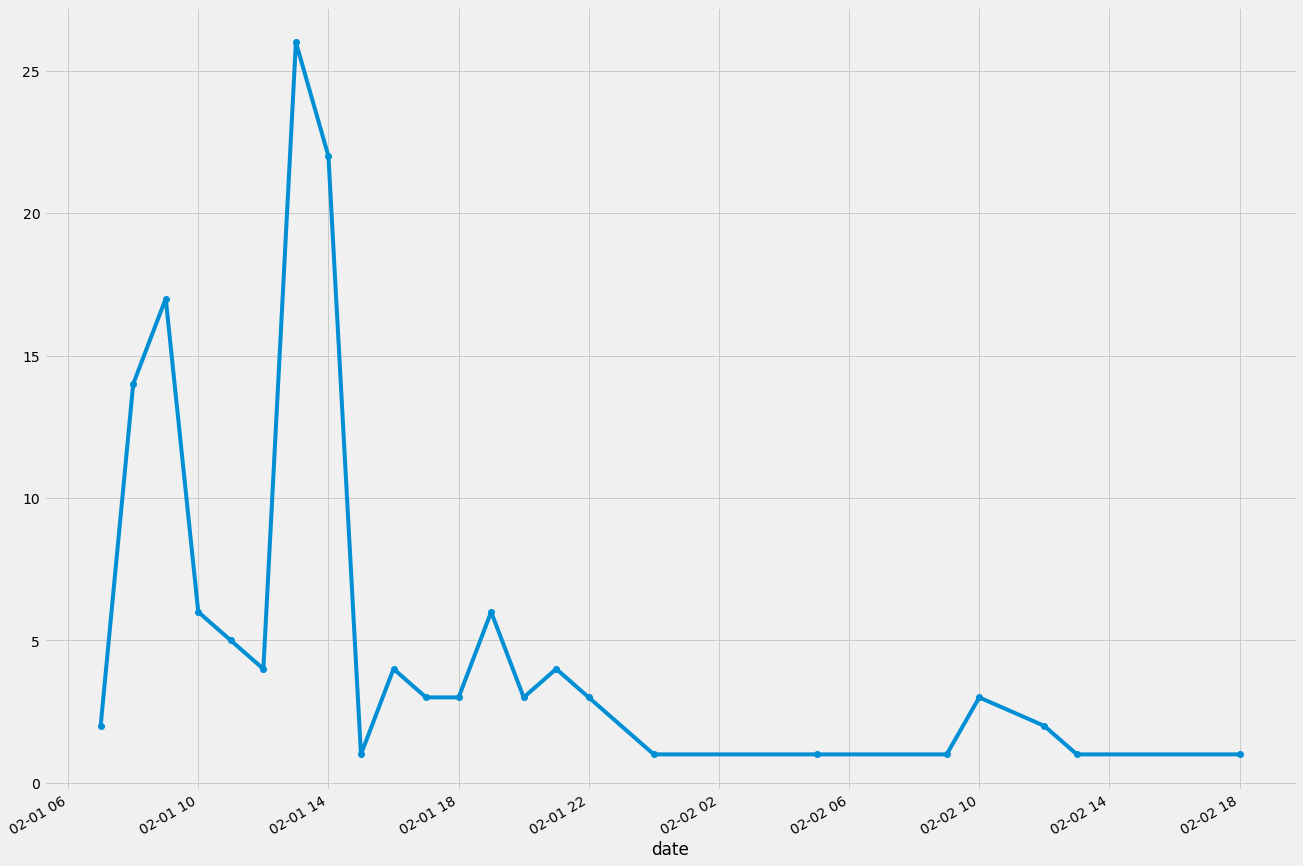

In [29]:
graph_count_DF.plot(marker='o')

In [30]:
print(graph_count_DF.idxmax())
print(graph_count_DF.max())

2017-02-01 13:00:00
26


## Coincidence Map Visualization

In [31]:
# shape_file_location = "/project/rcc/deep_learning_hack/dc-taxi/DCTaxiCab/data/shapefiles/dc_shapefiles/tl_2013_11_prisecroads.dbf"
# shape_file_location = "/project/rcc/deep_learning_hack/dc-taxi/DCTaxiCab/data/shapefiles/Ward_from_2012_shapefiles/Ward_from_2012.dbf"
shape_file_location = "/project/rcc/deep_learning_hack/dc-taxi/DCTaxiCab/data/shapefiles/Street_Centerlines_shapefiles/Street_Centerlines.dbf"
dc_shape = gpd.read_file(shape_file_location)

In [32]:
def get_square_vertex(coordinate):
    a = coordinate[0][0]
    b = coordinate[0][1]
    c = coordinate[1][0]
    d = coordinate[1][1]
    horz_diff = c - a
    vert_diff = b - d
    x_list = [a, a + horz_diff, 
              a + horz_diff, a]
    y_list = [b, b, b - vert_diff,
             b - vert_diff]
    return x_list, y_list

In [35]:
# Get a dataframe of the latitudes and longitudes of the coincidence data
drop_off_list = []

for results_pair in result_list:
    first_index = results_pair[0]
    drop_off_list.append([plot_DF.loc[first_index]['DROPOFF_BLOCK_LATITUDE'],
                          plot_DF.loc[first_index]['DROPOFF_BLOCK_LONGITUDE']]) #iloc


In [36]:
drop_off_DF = pd.DataFrame(drop_off_list)
drop_off_DF.columns = ['LATITUDE', 'LONGITUDE']
drop_off_DF = drop_off_DF.drop_duplicates()

In [37]:
WH_vertex = get_square_vertex(WH_square)
WP_vertex = get_square_vertex(WP_square)

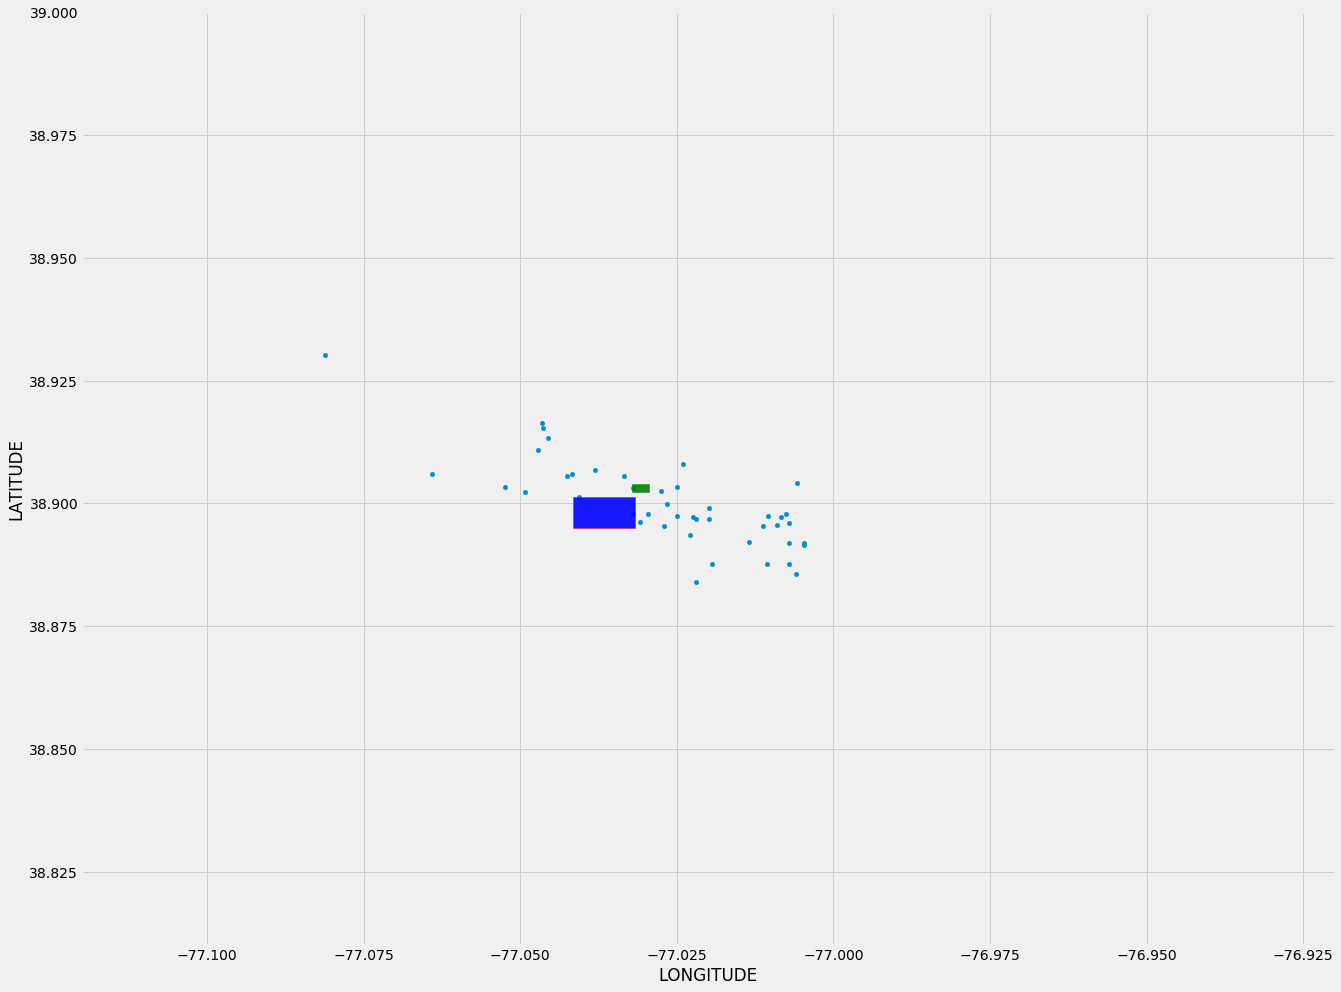

In [38]:
ax = drop_off_DF.plot.scatter('LONGITUDE', 'LATITUDE')
ax.fill(WH_vertex[1], WH_vertex[0], 'b', alpha=0.9, edgecolor='r')
ax.fill(WP_vertex[1], WP_vertex[0], 'g', alpha=0.9, edgecolor='g')
ax.set_xlim(-77.12, -76.92)
ax.set_ylim(38.810, 39.000)
plt.show()

In [39]:
WH_vertex

([38.901187, 38.895062, 38.895062, 38.901187],
 [-77.041623, -77.041623, -77.031594, -77.031594])

In [40]:
WH_square

[[38.901187, -77.041623], [38.895062, -77.031594]]

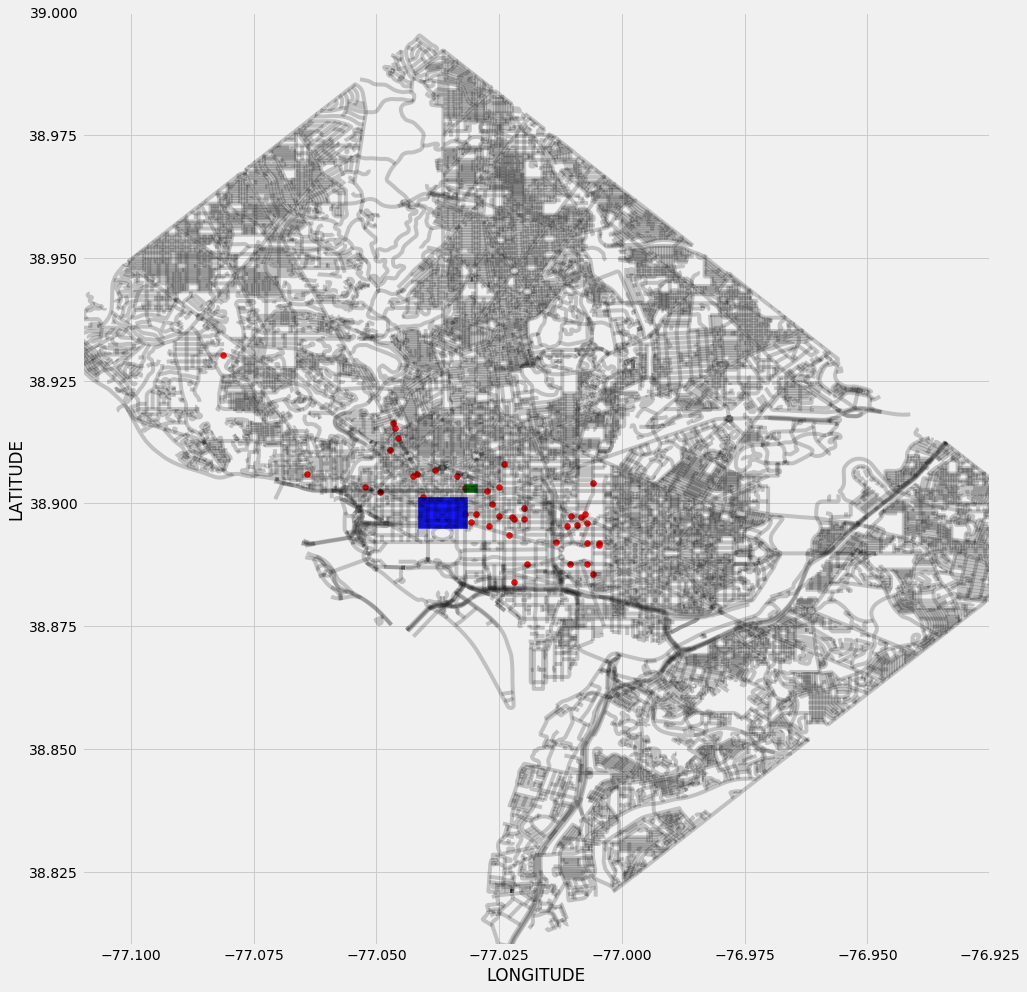

In [41]:
ax = dc_shape.plot(alpha = 0.2, color = 'k')
ax.scatter(drop_off_DF['LONGITUDE'], drop_off_DF['LATITUDE'], 
           color = 'r', alpha = 0.9)
ax.fill(WH_vertex[1], WH_vertex[0], color = 'b', 
        alpha=0.9, edgecolor='y')
ax.fill(WP_vertex[1], WP_vertex[0], color = 'g', 
        alpha=0.9, edgecolor='y')
ax.set_xlim(-77.11, -76.925)
ax.set_ylim(38.810, 39.000)
ax.set_xlabel("LONGITUDE")
ax.set_ylabel("LATITUDE")
plt.show()

In [44]:
# Get a dataframe of the latitudes and longitudes of the coincidence data
drop_off_date_list = []

for results_pair in result_list:
    first_index = results_pair[0]
    drop_off_date_list.append([plot_DF.loc[first_index]['DROPOFF_BLOCK_LATITUDE'],
                          plot_DF.loc[first_index]['DROPOFF_BLOCK_LONGITUDE'],
                          plot_DF.loc[first_index]['DROPOFFDATETIME_TR']]) #iloc

drop_off_date_DF = pd.DataFrame(drop_off_date_list)
drop_off_date_DF.columns = ['LATITUDE', 'LONGITUDE', 'DROPOFFDATETIME']
drop_off_date_DF = drop_off_date_DF.drop_duplicates()

In [45]:
drop_off_date = drop_off_date_DF['DROPOFFDATETIME'] 
drop_off_date = drop_off_date.apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0), 1)

In [46]:
drop_off_date_specific_DF = drop_off_date_DF[(drop_off_date == pd.to_datetime('2017-02-09')) | (drop_off_date == pd.to_datetime('2017-02-10'))]

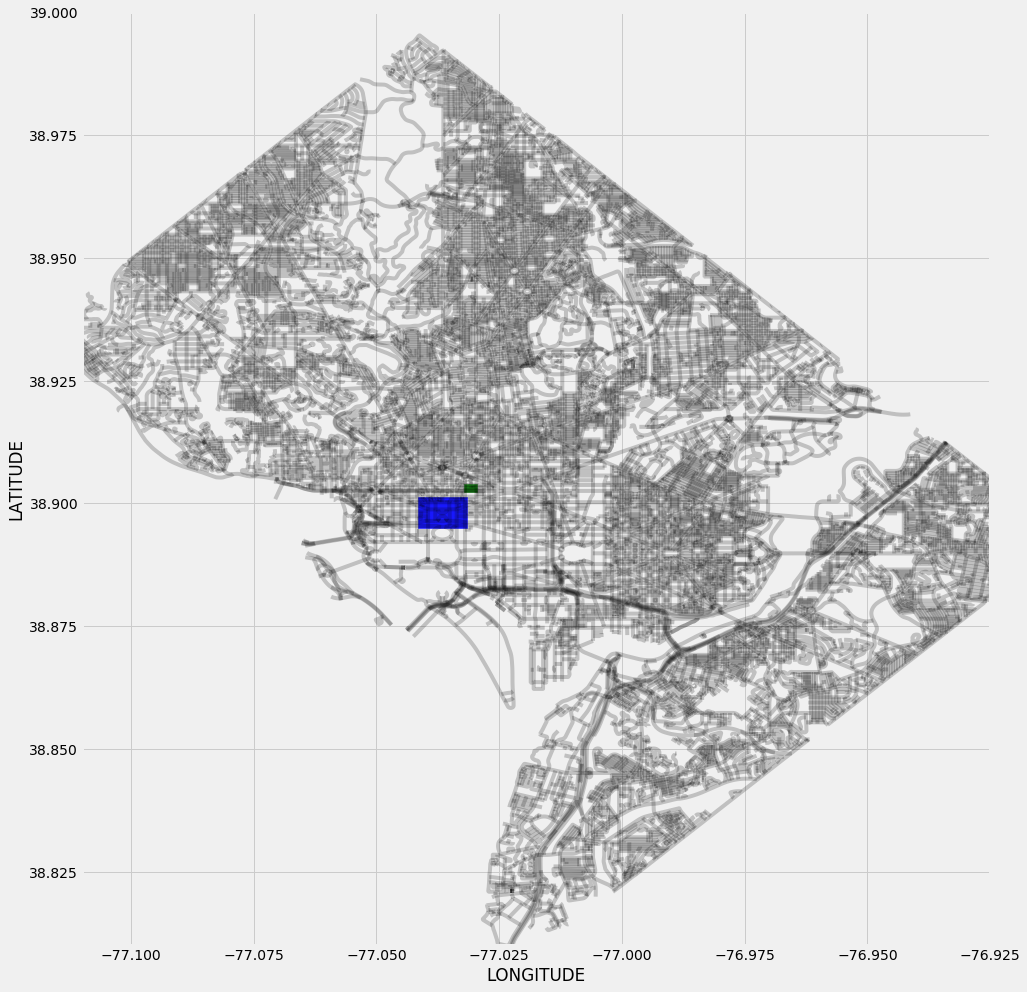

In [47]:
# Only For Feb 9th and 10th
ax = dc_shape.plot(alpha = 0.2, color = 'k')
ax.scatter(drop_off_date_specific_DF['LONGITUDE'], drop_off_date_specific_DF['LATITUDE'], 
           color = 'r', alpha = 0.9)
ax.fill(WH_vertex[1], WH_vertex[0], color = 'b', 
        alpha=0.9, edgecolor='y')
ax.fill(WP_vertex[1], WP_vertex[0], color = 'g', 
        alpha=0.9, edgecolor='y')
ax.set_xlim(-77.11, -76.925)
ax.set_ylim(38.810, 39.000)
ax.set_xlabel("LONGITUDE")
ax.set_ylabel("LATITUDE")
plt.show()

In [49]:
# drop_off_date_specific_DF

,LATITUDE,LONGITUDE,DROPOFFDATETIME
